# Custom Dataset Machine Learning Practice
Practice on creating custom datasets for use in machine learning applications using PyTorch

Two methods employed:
1. Use pre-existing dataset class from PyTorch (ImageFolder)
2. Create a custom dataloader class

Guided project from Learn PyTorch in a Day video by Daniel Bourke -
https://www.youtube.com/watch?v=Z_ikDlimN6A&t=91485s&pp=ygUNbGVhcm4gcHl0b3JjaA%3D%3D

In [1]:
import torch
from torch import nn

torch.__version__

'2.5.1+cu121'

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Get the dataset
- Subset of the Food101 dataset, downloaded from mrdbourkes pytorch-deep-learning repo
- Our dataset starts with only 3 classes, and 10% of the images

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If image folder doesn't exist, create the directory
if image_path.is_dir():
  print(f"{image_path} already exists, skipping...")
else:
  print(f"{image_path} doesn't exist, creating directory...")
  image_path.mkdir(parents = True, exist_ok = True)

# Download the picture data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading food data...")
  f.write(request.content)

# Unzip the file to image path
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping food data...")
  zip_ref.extractall(image_path)


data/pizza_steak_sushi already exists, skipping...
Unzipping food data...


In [4]:
import os

def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents"""

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")


In [5]:
# See the file structure of the data folder
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi.
There are 3 directories and 0 images in data/pizza_steak_sushi/test.
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi.
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza.
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak.
There are 3 directories and 0 images in data/pizza_steak_sushi/train.
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi.
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza.
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak.


In [6]:
# Setup train and test directory
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

# Visualise a random image from our dataset
1. Get all of the image paths
2. Pick a random image using random.choice()
3. Get the image class using `pathlib.Path.parent.stem`
4. Open image with Python's PIL
5. Show the image and print metadata

Random image path: data/pizza_steak_sushi/test/steak/502076.jpg
Image class: steak
Image height: 512
Image width: 512


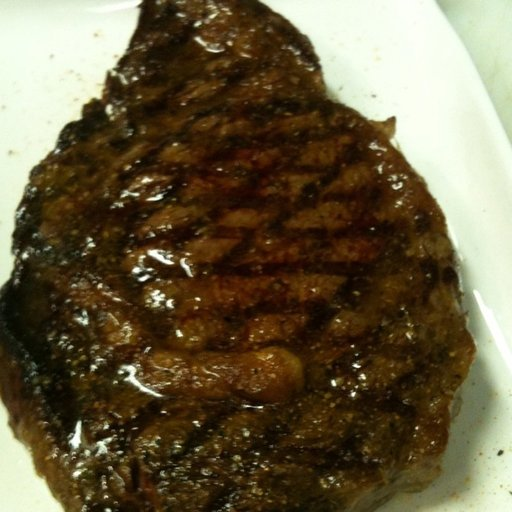

In [7]:
import random
from PIL import Image

random.seed(42)

# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Select a random path
random_image_path = random.choice(image_path_list)

# Get the image class from the pathname
image_class = random_image_path.parent.stem

# Open the image
img = Image.open(random_image_path)

# Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

img

Text(0.5, 1.0, 'Class: steak, Shape: (512, 512, 3)')

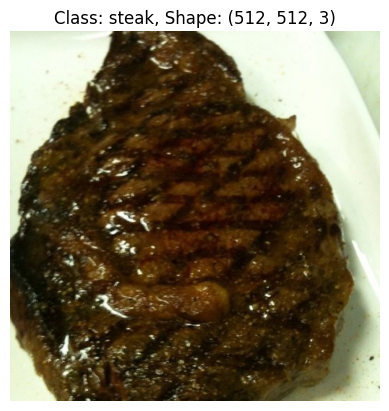

In [8]:
# Visualise the image with matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_array = np.asarray(img)


plt.imshow(img_array)
plt.axis(False)
plt.title(f"Class: {image_class}, Shape: {img_array.shape}")

In [9]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [10]:
# Write a transform for image (Resize -> Randomly flip -> convert to Tensor)
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

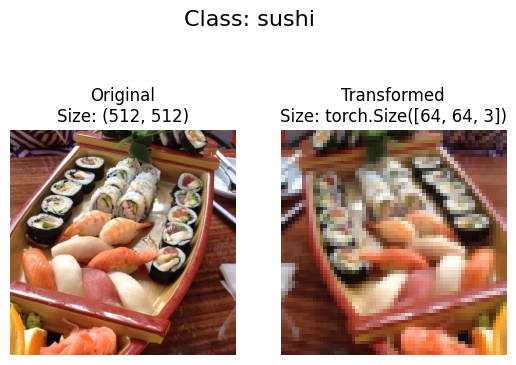

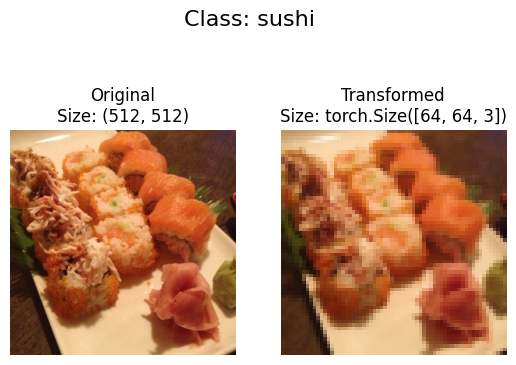

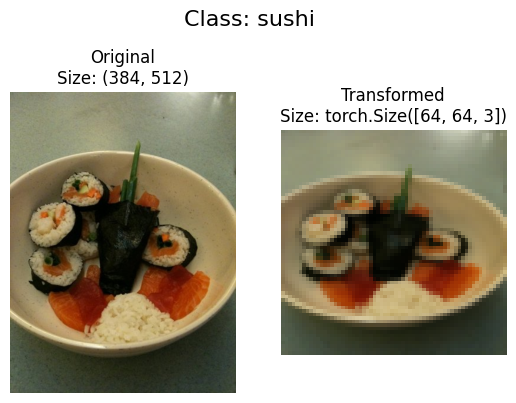

In [11]:
# Visualise the transformed image
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  """Takes in n number of images from the dataset, and plots them in their
  unaltered and transformed states for comparison"""

  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)

      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 16)

plot_transformed_images(image_path_list, data_transform, 3)




# Option 1 - Load image data using `ImageFolder`

In [12]:
# Use ImageFolder to create the datasets
from torchvision import datasets
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform,   # Data transform
                                  target_transform = None)      # Label transform

test_data = datasets.ImageFolder(root = test_dir,
                                  transform = data_transform,   # Data transform
                                  target_transform = None)      # Label transform

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [13]:
# Get classnames as list
class_names = train_data.classes

In [14]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [15]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

In [16]:
# Load data into dataloaders
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = 1,
                              num_workers = 1,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = 1,
                             num_workers = 1,
                             shuffle = False)

In [17]:
len(train_dataloader), len(test_dataloader)

(225, 75)

# Option 2: Loading data with a custom dataset
1. Want to be able to load images from file
2. Want to be able to get class names from datasets
3. Want to get classes as dictionary from dataset

In [18]:
# Import dependencies
import os
import pathlib
import torch
from torch import nn

from PIL import Image
from torch.utils.data import dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [19]:
# Instance of torchvision.datasets.Imagefolder()
train_data.classes, test_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

# Create a helper function to get the class names

In [20]:
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [21]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str,int]]:
  """Finds the class folder names in the target directory"""

  # Get the class names by scanning the directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # Raise an error if the class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")

  # Create dictionary of index labels for the classes
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [22]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

# Create a custom `Dataset` to replicate the functionality of `ImageFolder`

- Subclass `torch.utils.data.Dataset`
- Init our subclass with a target dir as well as a transform
- Create several attributes
  - Paths: image paths
  - Transform: transform to use
  - Classes: a list of target classes
  - class_to_idx: a dict of the target classes mapped to the integer labels
- Create a function `load_images()`, which will open an image
- Overwrite the `__len()__` method to return the length of our dataset
- Overwrite the `__getitem()__` method to return a given sample when passed an index

In [23]:
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Init custom dataset
  def __init__(self, targ_dir : str, transform = None):
    # 3. Create class attributes
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))         # Get all of the image paths
    self.transform = transform                                # Setup transform
    self.classes, self.class_to_idx = find_classes(targ_dir)  # Create classes and class dict attributes

  # 4. Create function to load images
  def load_image(self, index:int) -> Image.Image:
    """Opens an image via a path and returns it"""
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    """Returns the total number of samples"""
    return len(self.paths)

  # 6. Overwrite __getitem__() to return a particular sample
  def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
    """Returns one sample of data, data and label (X,y)."""
    img = self.load_image(index)
    class_name = self.paths[index].parent.name   # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx


In [24]:
# Create a transform
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [25]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform = train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transform = test_transforms)

In [26]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x78cf76f924d0>,
 <__main__.ImageFolderCustom at 0x78cf76f91330>)

In [27]:
len(train_data), len(train_data_custom)

(225, 225)

In [28]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [29]:
# Check for equality between original ImageFolder and ImageFolderCustom
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


# Create a function to display random images

In [30]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n:int = 10,
                          display_shape:bool = True,
                          seed: int = None):
  """Takes up to 10 random images from a dataset and displays them using matplotlib"""

  # Limit n to 10
  if n > 10:
    n=10
    display_shape = False
    print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and setting display_shape to False to avoid overlap")

  # Set seed
  if seed:
    random.seed(seed)

  # Get random sample indicies from the dataset
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # Setup plot
  plt.figure(figsize=(16,8))

  # Loop through the indicies and plot
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # Adjust tensor dimensions for plotting CHW -> HWC
    targ_image_adjust = targ_image.permute(1,2,0)

    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis(False)
    if classes:
      title = f"Class: {classes[targ_label]},{targ_label}"
      if display_shape:
        title = title + f"\nShape: {targ_image_adjust.shape}"
    plt.title(title)




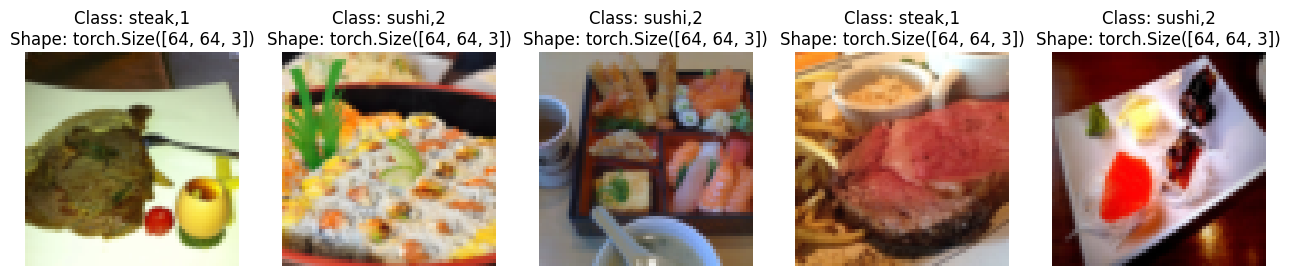

In [31]:
display_random_images(dataset = train_data_custom,
                      classes = class_names,
                      n = 5,
                      display_shape=True,
                      seed = 42)

# Turn our custom dataset into a Dataloader

In [32]:
BATCH_SIZE = 32 # Hyperparam

train_dataloader_custom = DataLoader(dataset = train_data_custom,
                                     batch_size = BATCH_SIZE,
                                     shuffle = True,
                                     num_workers = 1
                                     )

test_dataloader_custom = DataLoader(dataset = test_data_custom,
                                     batch_size = BATCH_SIZE,
                                     shuffle = False,
                                     num_workers = 1
                                     )

In [33]:
img_custom, label_custom = next(iter(train_dataloader_custom))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

# Data augmentation
Process of adding artificial diversity to the image data, through applying transforms

Lets focus on one type of augmentation that is used to train torchvision models to state of the art levels

Looking at trivialAugment

In [34]:
from torchvision import transforms

train_transform_aug = transforms.Compose([
    transforms.Resize(size=(224,224,)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_aug = transforms.Compose([
    transforms.Resize(size=(224,224,)),
    transforms.ToTensor()
])

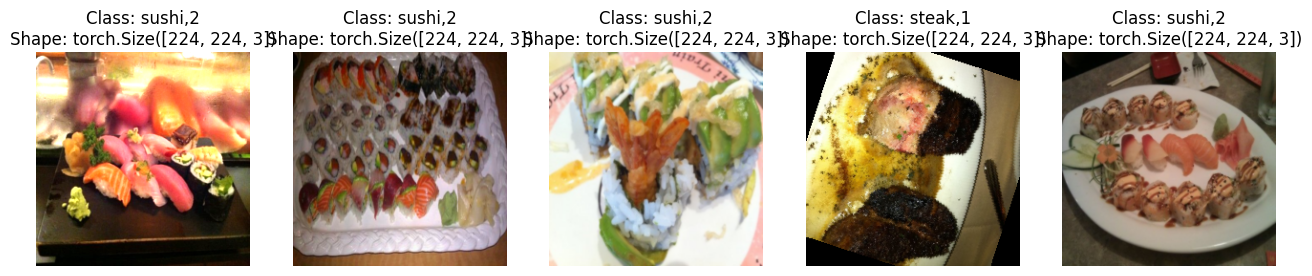

In [35]:
train_data_custom_aug = ImageFolderCustom(targ_dir=train_dir,
                                      transform = train_transform_aug)


test_data_custom_aug = ImageFolderCustom(targ_dir=test_dir,
                                         transform = test_transform_aug)

display_random_images(dataset = train_data_custom_aug,
                      classes = class_names,
                      n = 5,
                      display_shape = True,
                      seed = None)

In [36]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/sushi/479711.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2190404.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2521706.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/719108.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1600999.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/988559.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1245193.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2741434.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2276986.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/3806282.jpg')]

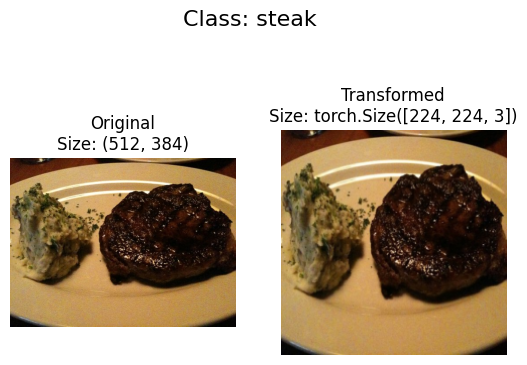

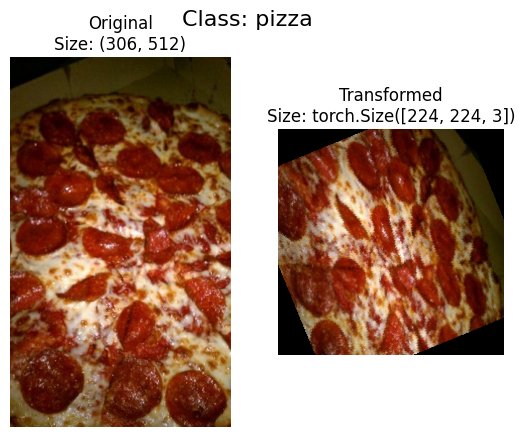

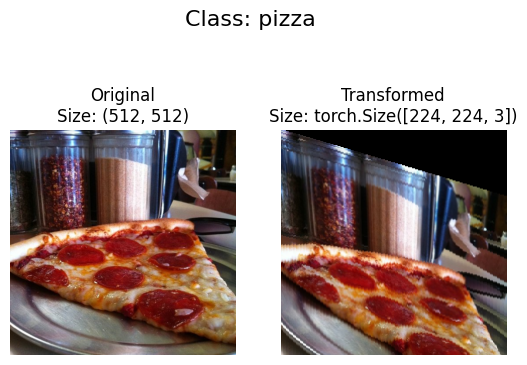

In [37]:
plot_transformed_images(image_path_list,
                        transform = train_transform_aug,
                        n=3,
                        seed=None)

# Baseline model: TinyVGG without data augmentation

In [38]:
class TVGGV1(nn.Module):
  """
  Model architecture that replicates TinyVGG model from CNN explainer website
  """

  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    # Construct convolutional blocks
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                    stride = 2)
      )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                    stride = 2)
        )

    # Construct classifier block
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*13*13,  # 13s are found by printing the output shapes of the conv layers, and using them to match the expected in shape for linear
                  out_features = output_shape)

    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)

    x = self.conv_block_2(x)
    # print(x.shape)

    x = self.classifier(x)
    # print(x.shape)

    return(x)


# Transforms, data and dataloader

In [39]:
# Create a simple data transform without any augmentation
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [40]:
# Load and transform data
train_data_simple = ImageFolderCustom(targ_dir = train_dir,
                                      transform =simple_transform)

test_data_simple = ImageFolderCustom(targ_dir = test_dir,
                                     transform = simple_transform)


# Create dataloaders for loaded data
BATCH_SIZE = 32
train_dataloader_simple = DataLoader(dataset = train_data_simple,
                                     batch_size = 32,
                                     shuffle = True,
                                     num_workers = 1)

test_dataloader_simple = DataLoader(dataset = test_data_simple,
                                     batch_size = 32,
                                     shuffle = False,
                                     num_workers = 1)

In [41]:
# Initialise instance of th model
model_0 = TVGGV1(3, 10, len(class_names))

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer_0 = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [42]:
# Pass dummy data through the model to track shape and find in_features for linear layer
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape

# Try forward pass
model_0(image_batch)

tensor([[ 3.9657e-02, -4.7480e-03,  8.6103e-03],
        [ 4.3506e-02, -1.0574e-02, -4.3402e-04],
        [ 3.8803e-02, -2.3377e-03,  7.6040e-03],
        [ 3.5761e-02,  5.0386e-03,  4.9049e-04],
        [ 3.9973e-02, -8.6645e-03,  1.2856e-02],
        [ 4.0481e-02, -8.6672e-03, -4.5319e-04],
        [ 4.1637e-02, -1.6167e-03,  8.5916e-03],
        [ 3.5473e-02, -3.0763e-03, -1.0872e-03],
        [ 4.1191e-02,  4.4862e-04, -1.2311e-03],
        [ 4.2600e-02, -1.4320e-03,  5.0703e-03],
        [ 3.7962e-02,  3.3057e-03, -1.9029e-04],
        [ 3.6921e-02, -1.8352e-03,  5.0167e-03],
        [ 4.5073e-02, -3.8642e-03,  2.1068e-03],
        [ 4.0318e-02, -5.6636e-03,  7.4268e-03],
        [ 3.8481e-02, -5.8013e-03, -2.6042e-03],
        [ 4.1150e-02, -8.2143e-03, -1.3987e-03],
        [ 4.4918e-02, -7.1571e-03,  1.1312e-02],
        [ 4.1808e-02, -2.9032e-03,  1.4096e-02],
        [ 4.3777e-02, -7.1539e-03,  1.1049e-02],
        [ 3.5508e-02, -2.8498e-03,  1.3761e-03],
        [ 3.5605e-02

In [43]:
# Import torch metrics and mlxtend for accuracy and confusion matrix metrics

# Check if required packages are in google colab, and if not, import
try:
  import torchmetrics as tm
  import mlxtend as mlx
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend version needs to be 0.19.0 or higher"
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics as tm
  import mlxtend as mlx
  print(f"mlxtend version: {mlx.__version__}")


  from torchmetrics.classification import MulticlassAccuracy

mlxtend version: 0.23.3


In [44]:
# Install torchinfo and import if its available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary

In [45]:
summary(model_0, input_size=(1,3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
TVGGV1                                   [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

# Train Step

In [46]:
# Functionise training and testing loops
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  """
    Performs training step with model trying to learn on data loader
  """

  train_loss, train_acc = 0, 0

  model.to(device)

  # Print what device the data is on
  print(f"Data is on {device}")

  # Put model into training mode
  model.train()

  # Add a loop to loop through training batches
  for batch, (X, y) in enumerate(data_loader):

    # Put data on the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward Pass
    y_hat = model(X)

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_hat, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # Optimizer step, step, step - optimizer is being stepped once per batch
    optimizer.step()

    # Calculate accuracy
    y_hat_class = torch.argmax(torch.softmax(y_hat, dim=1), dim=1)
    train_acc += (y_hat_class==y).sum().item()/len(y_hat)

    # # Print out whats happening
    # if batch % 400 == 0:
    #   print(f"Looked at {batch * len(X)}/{len(data_loader.dataset)} samples")

  # Divide total train loss and accuracy by the length of the dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  return train_loss, train_acc

# Test Step

In [47]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
    """
      Performs testing step and calculates testing loss and accuracy
    """
    test_loss, test_acc = 0, 0

    model.to(device)

    # Set the model to eval mode
    model.eval()
    with torch.inference_mode():
      for X, y in data_loader:

        # Put data on the target device
        X = X.to(device)
        y = y.to(device)

        # Forward Pass
        test_pred = model(X)

        # Calculate Loss and accuracy
        loss = loss_fn(test_pred, y)
        test_loss += loss.item()

        # Calculate the accuracy
        test_pred_class = torch.argmax(torch.softmax(test_pred, dim=1),dim=1)
        test_acc += ((test_pred_class==y).sum().item()/len(test_pred))

      # Calculate the avg test loss per batch
      test_loss /= len(data_loader)

      # Calculate avg acc per batch
      test_acc /= len(data_loader)

      return test_loss, test_acc

# Combine train and test steps in train function


In [48]:
# Import timer and progress bar
from tqdm.auto import tqdm
from timeit import default_timer as timer

# Create function to track training time
def print_train_time(start: float, end: float, device: torch.device = None):
  """
  Prints difference between start and end times for NN model

  start (float): time at which the training process starts
  end (float): time at which the training process ends
  device (torch.device): the device on which the model was trained (cpu or gpu)
  """

  total_time = end-start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [49]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dict
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}


  for epoch in tqdm(range(epochs)):

    # Run train function
    train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer,  device)

    # Run test function
    test_loss, test_acc = test_step(model, test_dataloader, loss_fn,  device)

    # 4. Print out what's happening
    print(
        f"Epoch: {epoch+1} | "
        f"train_loss: {train_loss:.4f} | "
        f"train_acc: {train_acc:.4f} | "
        f"test_loss: {test_loss:.4f} | "
        f"test_acc: {test_acc:.4f}"
    )

    # 5. Update results dictionary
    # Ensure all data is moved to CPU and converted to float for storage
    # results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    # results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    # results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
    # results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)


  # 6. Return the filled results at the end of the epochs
  return results


# Now train and test the baseline model

In [50]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

EPOCHS = 20

model_0 = TVGGV1(3,10,len(class_names))

optimizer = torch.optim.Adam(params = model_0.parameters(), lr=0.001)

start_time = timer()

# Run the train function
results = train(model_0, train_dataloader_simple, test_dataloader_simple, optimizer=optimizer, epochs=EPOCHS)

end_time = timer()

print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Data is on cuda
Epoch: 1 | train_loss: 1.1038 | train_acc: 0.3047 | test_loss: 1.1034 | test_acc: 0.2604
Data is on cuda
Epoch: 2 | train_loss: 1.0987 | train_acc: 0.3242 | test_loss: 1.0885 | test_acc: 0.4167
Data is on cuda
Epoch: 3 | train_loss: 1.0760 | train_acc: 0.4961 | test_loss: 1.0976 | test_acc: 0.4233
Data is on cuda
Epoch: 4 | train_loss: 1.0734 | train_acc: 0.5312 | test_loss: 1.0837 | test_acc: 0.3902
Data is on cuda
Epoch: 5 | train_loss: 1.0431 | train_acc: 0.5508 | test_loss: 1.0837 | test_acc: 0.4129
Data is on cuda
Epoch: 6 | train_loss: 0.9718 | train_acc: 0.5938 | test_loss: 1.0305 | test_acc: 0.4309
Data is on cuda
Epoch: 7 | train_loss: 0.8926 | train_acc: 0.6016 | test_loss: 1.0690 | test_acc: 0.4025
Data is on cuda
Epoch: 8 | train_loss: 1.0452 | train_acc: 0.4375 | test_loss: 0.9675 | test_acc: 0.4527
Data is on cuda
Epoch: 9 | train_loss: 0.9338 | train_acc: 0.4766 | test_loss: 1.0310 | test_acc: 0.4025
Data is on cuda
Epoch: 10 | train_loss: 0.9625 | train_

In [52]:
# Plot loss curves of baseline model
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots loss curves of a results dict"""

  plt.figure(figsize=(15,7))

  epochs = range(len(results["train_loss"]))
  train_loss = results["train_loss"]
  train_acc = results["train_acc"]
  test_loss = results["test_loss"]
  test_acc = results["test_acc"]


  # Plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs, train_loss, label="Train Loss")
  plt.plot(epochs, test_loss, label="Test Loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, train_acc, label="Train acc")
  plt.plot(epochs, test_acc, label="Test acc")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();





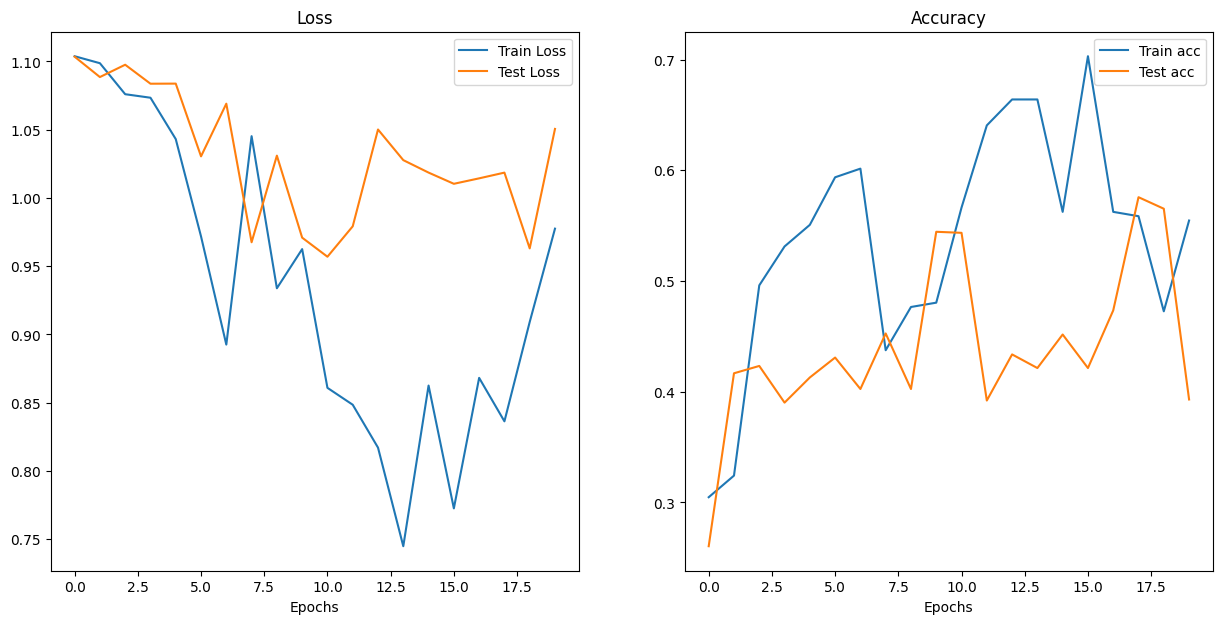

In [53]:
plot_loss_curves(results)

# Repeat for augmented data

In [54]:
train_transform_trivial = transforms.Compose([transforms.Resize(size=(64,64)),
                                              transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                              transforms.ToTensor()])

test_transform_simple = transforms.Compose([transforms.Resize(size=(64,64)),
                                              transforms.ToTensor()])

In [55]:
train_data_trivial = ImageFolderCustom(targ_dir = train_dir,
                                         transform = train_transform_trivial)

test_data_simple = ImageFolderCustom(targ_dir = test_dir,
                                         transform = test_transform_simple)

train_dataloader_trivial = DataLoader(dataset = train_data_trivial,
                                     batch_size = 32,
                                     shuffle = True,
                                     num_workers = 1)

test_dataloader_simple = DataLoader(dataset = test_data_simple,
                                     batch_size = 32,
                                     shuffle = False,
                                     num_workers = 1)



In [56]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

EPOCHS = 20

model_1 = TVGGV1(3,10,len(class_names))

optimizer_1 = torch.optim.Adam(params = model_1.parameters(), lr=0.001)

start_time = timer()

# Run the train function
results_1 = train(model_1, train_dataloader_trivial, test_dataloader_simple, optimizer=optimizer_1, epochs=EPOCHS)

end_time = timer()

print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Data is on cuda
Epoch: 1 | train_loss: 1.1052 | train_acc: 0.3047 | test_loss: 1.1050 | test_acc: 0.2604
Data is on cuda
Epoch: 2 | train_loss: 1.0991 | train_acc: 0.3438 | test_loss: 1.0917 | test_acc: 0.4167
Data is on cuda
Epoch: 3 | train_loss: 1.0842 | train_acc: 0.4453 | test_loss: 1.0971 | test_acc: 0.5133
Data is on cuda
Epoch: 4 | train_loss: 1.0949 | train_acc: 0.3711 | test_loss: 1.0898 | test_acc: 0.4915
Data is on cuda
Epoch: 5 | train_loss: 1.0806 | train_acc: 0.3984 | test_loss: 1.0971 | test_acc: 0.3523
Data is on cuda
Epoch: 6 | train_loss: 1.0562 | train_acc: 0.5352 | test_loss: 1.0715 | test_acc: 0.4403
Data is on cuda
Epoch: 7 | train_loss: 1.0107 | train_acc: 0.5703 | test_loss: 1.0550 | test_acc: 0.4025
Data is on cuda
Epoch: 8 | train_loss: 1.0473 | train_acc: 0.4219 | test_loss: 1.0316 | test_acc: 0.4129
Data is on cuda
Epoch: 9 | train_loss: 1.0310 | train_acc: 0.3750 | test_loss: 1.0097 | test_acc: 0.4025
Data is on cuda
Epoch: 10 | train_loss: 0.9740 | train_

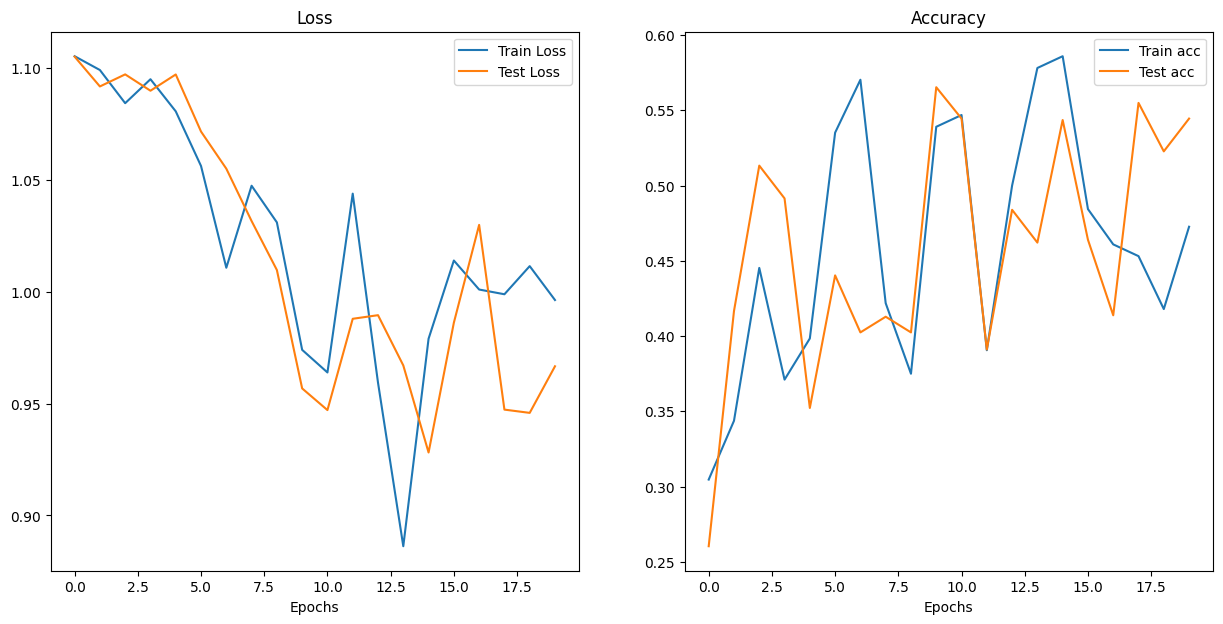

In [57]:
plot_loss_curves(results_1)

# Making a prediction on a custom image
Making a prediction on an image that isnt in the train or test dataset
We can read in custom images using PyTorch readimage

In [81]:
import requests

custom_image_path = data_path / "pizza-dad.jpeg"

# Download the image if it doesn't already exist

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)

else:
  print(f"Custom image already exists, skipping download...")

Custom image already exists, skipping download...


torch.float32


(-0.5, 3023.5, 4031.5, -0.5)

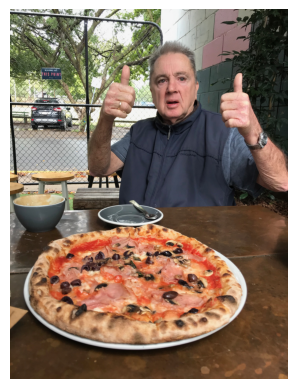

In [82]:
# Make sure the custom image is in the same format as training and test data
import torchvision
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path)) / 255 # Values need to be between 0 and 1, so scale
print(custom_image_uint8.dtype)
plt.imshow(custom_image_uint8.permute(1,2,0))
plt.axis(False)

In [83]:
# Convert the image to a torch.float32 tensor
custom_image_transform = transforms.Compose([transforms.Resize(size=(64,64))])

custom_image_transformed = custom_image_transform(custom_image_uint8)

custom_image_transformed.shape

torch.Size([3, 64, 64])

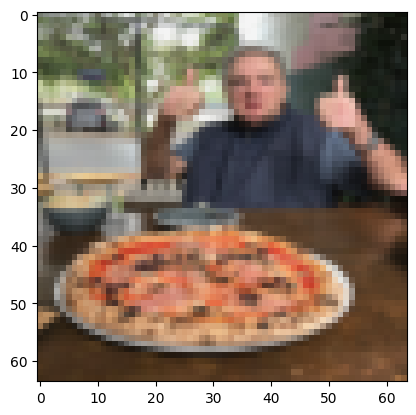

In [84]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [85]:
# Add batch size
custom_image_transformed = custom_image_transformed.unsqueeze(0).to(device)
print(custom_image_transformed.shape)

custom_image_transformed.device

torch.Size([1, 3, 64, 64])


device(type='cuda', index=0)

In [86]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed)


In [87]:
pred = torch.argmax(torch.softmax(custom_image_pred, dim=1), dim=1)
print(class_names[pred])

steak


# Build a function that can load custom data and predict on it

In [88]:
def predict_custom(model: torch.nn.Module,
                   img_path: pathlib.Path,
                   class_names: List[str] = None,
                   transform: torchvision.transforms = None,
                   device: torch.device = device):

  # Read the image using torchvision read image
  custom_img = torchvision.io.read_image(str(img_path)) / 255 # Values need to be between 0 and 1, so scale

  # Transform image to match the train data format
  if transform:
    custom_img_transformed = transform(custom_img)

  # Add batch dimension
  custom_img_unsqueezed = custom_img_transformed.unsqueeze(0)

  model.to(device)

  # Make prediction
  model.eval()
  with torch.inference_mode():
    pred = model(custom_img_unsqueezed.to(device))

  # Logits -> Probabilites
  pred_prob = torch.softmax(pred, dim=1)

  # Probs -> Labels
  pred_label = torch.argmax(pred_prob, dim=1)

  # Plot the image alongside the predicted label
  plt.imshow(custom_img.permute(1,2,0))
  if class_names:
    title = f"Pred: {class_names[pred_label]} | Prob: {pred_prob.max()}"
  else:
    title = f"Pred: {pred_label} | Prob: {pred_prob.max()}"

  plt.title(title)
  plt.axis(False)




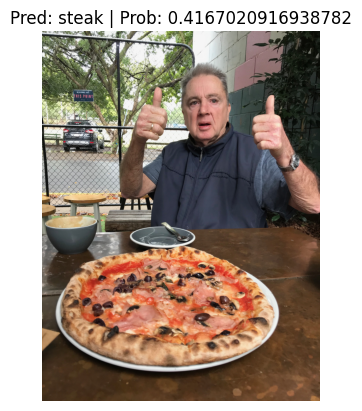

In [89]:
predict_custom(model_1,
               custom_image_path,
               class_names,
               custom_image_transform,
               device = "cuda")
